# MLOps Stack para otimização de hiperparâmetros com MLflow e Optuna

O objetivo deste projeto é desenvolver uma solução de MLOps que integre MLflow e Optuna para otimizar hiperparâmetros em modelos de modelo XGBoost de regressão para previsão de demanda. A solução deve ser capaz treinar experimentos, gerenciar versões do modelo automatizar o rocesso otimização e hiperparâmetros, garantindo assim um modelo mais preciso e eficiente. O processo de operacionalização o modelo deve ainda gerar artefatos para a melhor versão do modelo, que então será usado para inferência. Usaremos dos fictícios, com a demanda sendo variável alvo. O projeto inclui o dicionário de dados.

In [6]:
import sys
#!{sys.executable} -m pip install optuna
#!{sys.executable} -m pip install mlflow
#!{sys.executable} -m pip install xgboost

In [2]:
# Imports
import json
import math
import sklearn
import optuna
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

/home/priscila/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregando dados de texto

In [3]:
dados = pd.read_csv("/home/priscila/Downloads/04-MLOps/dados/dataset1.csv")
dados.head()

,data,temperatura_media,precipitacao,fim_de_semana,feriado,preco_por_kg,promocao,demanda,demanda_dos_dias_anteriores,preco_por_kg_do_concorrente,intensidade_de_marketing
0,2010-10-18 09:16:07.883826,30.584727,1.199291,0,0,1.726258,1,1051.375336,1051.276659,1.935346,0.098677
1,2010-10-19 09:16:07.883825,15.465069,1.037626,0,0,0.576471,1,1106.855943,1051.276659,2.344720,0.019318
2,2010-10-20 09:16:07.883824,10.786525,5.656089,0,0,2.513328,1,1008.304909,1106.836626,0.998803,0.409485
3,2010-10-21 09:16:07.883823,23.648154,12.030937,0,0,1.839225,1,999.833810,1057.895424,0.761740,0.872803
4,2010-10-22 09:16:07.883822,13.861391,4.303812,0,0,1.531772,1,1183.949061,1048.961007,2.123436,0.820779


In [5]:
dados.shape

(5000, 11)

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   data                         5000 non-null   object 
 1   temperatura_media            5000 non-null   float64
 2   precipitacao                 5000 non-null   float64
 3   fim_de_semana                5000 non-null   int64  
 4   feriado                      5000 non-null   int64  
 5   preco_por_kg                 5000 non-null   float64
 6   promocao                     5000 non-null   int64  
 7   demanda                      5000 non-null   float64
 8   demanda_dos_dias_anteriores  5000 non-null   float64
 9   preco_por_kg_do_concorrente  5000 non-null   float64
 10  intensidade_de_marketing     5000 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 429.8+ KB


In [4]:
# Ajustar a coluna de data para o tipo correto
dados['data'] = pd.to_datetime(dados['data'])

In [8]:
dados.describe()

,data,temperatura_media,precipitacao,fim_de_semana,feriado,preco_por_kg,promocao,demanda,demanda_dos_dias_anteriores,preco_por_kg_do_concorrente,intensidade_de_marketing
count,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2017-08-21 21:16:07.881014528,22.433182,4.962877,0.285600,0.033000,1.758228,0.289000,1258.452333,1282.446665,1.769682,0.848173
min,2010-10-18 09:16:07.883826,10.002439,0.000071,0.000000,0.000000,0.500360,0.000000,707.952882,757.216503,0.500754,0.019318
25%,2014-03-21 03:16:07.882367232,16.311898,1.440718,0.000000,0.000000,1.134110,0.000000,1066.040653,1089.993191,1.160719,0.773080
50%,2017-08-21 21:16:07.881031424,22.400265,3.520515,0.000000,0.000000,1.776194,0.000000,1222.237635,1244.619215,1.764809,0.848107
75%,2021-01-22 15:16:07.879706624,28.570768,6.805668,1.000000,0.000000,2.383638,1.000000,1422.792698,1445.791858,2.401827,0.928536
max,2024-06-25 09:16:07.878116,34.995334,40.072693,1.000000,1.000000,2.999606,1.000000,2183.463942,2182.608701,2.999847,0.999979
std,NaN,7.146610,4.932382,0.451745,0.178654,0.725334,0.453343,253.240475,249.087488,0.721041,0.093135


## Dicionário

In [5]:
# Carrega o arquivo JSON
with open('/home/priscila/Downloads/04-MLOps/dados/dicionario_de_dados.json', 'r') as arquivo:
    dicionario_de_dados = json.load(arquivo)

In [6]:
df_dicionario = pd.DataFrame.from_dict(dicionario_de_dados, orient = 'index')
df_dicionario

,descrição,tipo
data,Data e hora em que os dados foram registrados.,datetime
temperatura_media,Temperatura média registrada na data.,float
precipitacao,Quantidade de precipitação registrada na data.,float
fim_de_semana,Indica se o dia é um fim de semana (1) ou não ...,int
feriado,Indica se o dia é um feriado (1) ou não (0).,int
preco_por_kg,Preço por kg do produto vendido.,float
promocao,Indica se havia uma promoção ativa (1) ou não ...,int
demanda,Demanda do produto na data.,float
demanda_dos_dias_anteriores,Demanda do produto no dia anterior.,float
preco_por_kg_do_concorrente,Preço por kg do produto oferecido por um conco...,float


## Funções para gráficos

In [7]:
# Função para o plot da correlação das variáveis preditoras com a variável alvo (demanda)
def plot_corr_demanda(df, save_path = None):

    # Calcula as correlações das variáveis com a demanda, exceto a própria demanda
    correlations = df.corr()["demanda"].drop("demanda").sort_values()

    # Define uma paleta de cores divergentes
    colors = sns.diverging_palette(10, 130, as_cmap = True)
    
    # Mapeia as cores às correlações
    color_mapped = correlations.map(colors)

    # Define o estilo do gráfico
    sns.set_style("darkgrid", {"axes.facecolor": "#eaeaf2", "grid.linewidth": 1.5})

    # Cria a figura do plot com tamanho definido
    fig = plt.figure(figsize = (12, 8))
    
    # Cria um gráfico de barras horizontais para as correlações
    plt.barh(correlations.index, correlations.values, color = color_mapped)

    # Define o título e os rótulos dos eixos do gráfico
    plt.title("Correlação com Demanda", fontsize = 16)
    plt.xlabel("Coeficiente de Correlação", fontsize = 14)
    plt.ylabel("Variável", fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(axis="x")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Salva o gráfico como um arquivo PNG, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format = "png", dpi = 600)

    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

### Vizualizando a correlação dos dados com a variável alvo (Demanda)

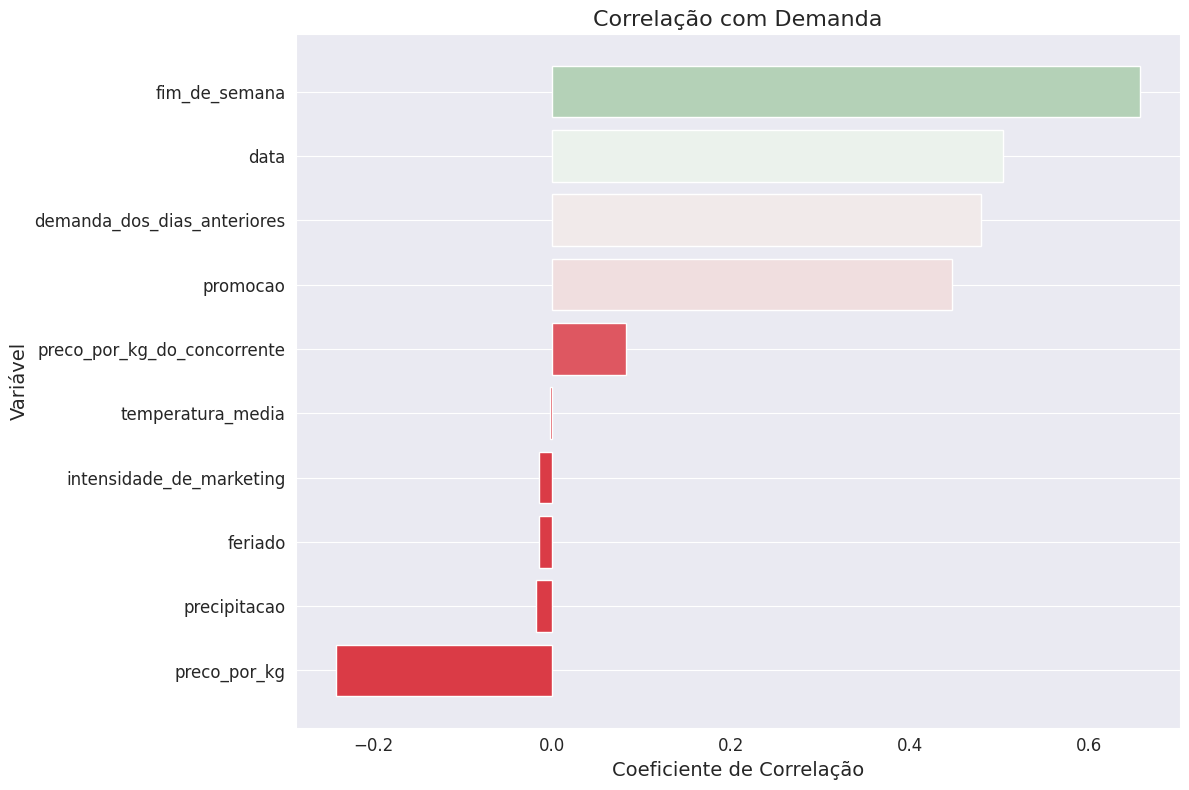

In [20]:
plot_corr_demanda(dados)

In [8]:
# Função para plot dos resíduos do modelo
def plot_residuos(model, dvalid, valid_y, save_path = None):

    # Faz as previsões no conjunto de validação
    preds = model.predict(dvalid)

    # Calcula os resíduos (diferença entre valores reais e previstos)
    residuals = valid_y - preds

    # Define o estilo do gráfico para 'whitegrid'
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Cria a figura do plot com tamanho definido
    fig = plt.figure(figsize = (12, 8))
    
    # Cria um gráfico de dispersão dos valores reais versus resíduos
    plt.scatter(valid_y, residuals, color = "blue", alpha = 0.5)
    
    # Adiciona uma linha horizontal em y=0
    plt.axhline(y = 0, color = "r", linestyle = "-")

    # Define o título e os rótulos dos eixos do gráfico
    plt.title("Resíduos x Valores Reais", fontsize = 16)
    plt.xlabel("Valores Reais", fontsize = 14)
    plt.ylabel("Resíduos", fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(axis = "y")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Salva o gráfico como um arquivo PNG, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format = "png", dpi = 600)

    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

In [9]:
# Função para plot da importância das variáveis
def plot_feature_importance(model, booster):

    # Cria a figura e o eixo para o plot com tamanho definido
    fig, ax = plt.subplots(figsize = (10, 8))
    
    # Define o tipo de importância como "weight" se o booster for "gblinear", caso contrário "gain"
    importance_type = "weight" if booster == "gblinear" else "gain"
    
    # Plot das importância das variáveis usando o XGBoost
    xgb.plot_importance(model,
                        importance_type = importance_type,
                        ax = ax,
                        title = f"Feature Importance baseada em {importance_type}")
    
    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    
    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

## Criando o Experimento no MLFlow

In [10]:
# Função para criar o experimento
def cria_experimento(experiment_name):

    # Verifica se o experimento já existe pelo nome
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        # Se o experimento existir, retorna seu ID
        return experiment.experiment_id
    else:
        # Se o experimento não existir, cria um novo e retorna seu ID
        return mlflow.create_experiment(experiment_name)

In [11]:
# Cria o experimento
id_experimento_mlops_p1 = cria_experimento("MLOpsProjeto1")

2025/12/27 15:12:26 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/27 15:12:26 INFO mlflow.store.db.utils: Updating database tables
2025/12/27 15:12:26 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/27 15:12:26 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/27 15:12:26 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/27 15:12:26 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/27 15:12:26 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/27 15:12:26 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/27 15:12:26 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/27 15:12:26 INFO alembic.runtime.migration: Running 

In [12]:
id_experimento_mlops_p1

'1'

```mlflow ui --port 8282```

Visualizar no navegador: http://127.0.0.1:8282

In [13]:
mlflow.set_experiment(experiment_id = id_experimento_mlops_p1)

<Experiment: artifact_location='/home/priscila/repos/machine-learning/04-mlops/01-Otimizacao-Hiperparametros/mlruns/1', creation_time=1766859147793, experiment_id='1', last_update_time=1766859147793, lifecycle_stage='active', name='MLOpsProjeto1', tags={}>

## Pré-Processamento para o experimento

In [14]:
# Separa em X e y
X = dados.drop(columns = ["data", "demanda"])
y = dados["demanda"]

In [15]:
# Divide os dados em treino e validação
x_treino, x_valid, y_treino, y_valid = train_test_split(X, y, test_size = 0.25)

In [16]:
# Coloca os dados no formato de matriz do XGBoost
treino = xgb.DMatrix(x_treino, label = y_treino)
valid = xgb.DMatrix(x_valid, label = y_valid)

In [17]:
treino

In [18]:
print(treino.get_data())

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 33750 stored elements and shape (3750, 9)>
  Coords	Values
  (0, 0)	16.596036911010742
  (0, 1)	7.5872273445129395
  (0, 2)	1.0
  (0, 3)	0.0
  (0, 4)	2.402582883834839
  (0, 5)	0.0
  (0, 6)	946.3889770507812
  (0, 7)	1.4093451499938965
  (0, 8)	0.952782154083252
  (1, 0)	18.511585235595703
  (1, 1)	6.243416786193848
  (1, 2)	0.0
  (1, 3)	0.0
  (1, 4)	2.3732051849365234
  (1, 5)	0.0
  (1, 6)	1209.54296875
  (1, 7)	2.0941240787506104
  (1, 8)	0.7137632369995117
  (2, 0)	11.39807415008545
  (2, 1)	1.2384369373321533
  (2, 2)	1.0
  (2, 3)	0.0
  (2, 4)	2.374108076095581
  (2, 5)	0.0
  (2, 6)	1471.7247314453125
  :	:
  (3747, 2)	0.0
  (3747, 3)	0.0
  (3747, 4)	1.6745023727416992
  (3747, 5)	1.0
  (3747, 6)	947.45751953125
  (3747, 7)	1.4770077466964722
  (3747, 8)	0.7987493872642517
  (3748, 0)	28.781661987304688
  (3748, 1)	2.5154097080230713
  (3748, 2)	0.0
  (3748, 3)	1.0
  (3748, 4)	2.611117124557495
  (3748, 5)	0.0
  (3748, 6

In [19]:
# Substitui o registro padrão do Optuna apenas para ERROR
optuna.logging.set_verbosity(optuna.logging.ERROR)
# Apenas mensagens de erro serão mostradas.
# Logs de WARNING, INFO e DEBUG são suprimidos.

## Definindo o Callback de Logging

Registro de retorno de chamada que informará quando uma nova iteração de teste melhorar a existente.

Esse código define um **callback do Optuna** que é executado ao final de cada trial.
A função serve para detectar quando surge um novo melhor resultado (best_value) e imprimir o quanto ele melhorou em relação ao melhor anterior.

In [20]:
# Função de callback
def callback(study, frozen_trial):

    # Obtém o valor atual do "winner" (vencedor) dos atributos do estudo
    winner = study.user_attrs.get("winner", None)

    # Verifica se há um novo melhor valor e se o "winner" não é igual ao melhor valor
    if study.best_value and winner != study.best_value:
        
        # Define o novo melhor valor como "winner"
        study.set_user_attr("winner", study.best_value)
        
        # Se havia um "winner" anterior
        if winner:
            
            # Calcula a porcentagem de melhoria em relação ao "winner" anterior
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            
            # Imprime o número da tentativa, o valor alcançado e a porcentagem de melhoria
            print(
                f"Tentativa {frozen_trial.number} alcançou o valor: {frozen_trial.value} com "
                f"{improvement_percent: .4f}% de melhora na métrica de avaliação.")
        else:
            # Se não havia um "winner" anterior, imprime o número da tentativa inicial e o valor alcançado
            print(
                f"Tentativa inicial {frozen_trial.number} alcançou o valor: "
                f"{frozen_trial.value} na métrica de avaliação.")

## Definindo os Hiperparâmetros do XGBoost para o experimento

Essa função é a função objetivo do Optuna.\
Ela define quais hiperparâmetros do XGBoost serão testados, treina o modelo, avalia no conjunto de validação e retorna o erro para o Optuna decidir se aquele trial foi bom ou ruim.\
Além disso, ela registra tudo no MLflow.

In [ ]:
# Função para definir os hiperparâmetros que serão otimizados
def otimiza_hiperparametro(trial):
    """
    Função objetivo utilizada pelo Optuna para otimização de hiperparâmetros
    de um modelo XGBoost de regressão.

    A cada trial, esta função:
    1. Define um conjunto de hiperparâmetros a partir do espaço de busca.
    2. Treina um modelo XGBoost com esses hiperparâmetros.
    3. Avalia o modelo em um conjunto de validação.
    4. Registra parâmetros e métricas no MLflow.
    5. Retorna o erro para guiar o processo de otimização do Optuna.

    Parâmetros
    ----------
    trial : optuna.trial.Trial
        Objeto do Optuna responsável por sugerir valores de hiperparâmetros
        e armazenar informações do trial atual.

    Retorno
    -------
    float
        Erro quadrático médio (MSE) calculado no conjunto de validação.
        Este valor é minimizado pelo Optuna.
    """
    
    # Inicia uma nova execução de MLflow
    with mlflow.start_run(nested = True):
        
        # Define os hiperparâmetros básicos do modelo
        params = {
            
            # Função alvo (objetivo)
            "objective": "reg:squarederror",
            
            # Métrica de avaliação
            "eval_metric": "rmse",
            
            # Tipo de booster (algoritmo de treinamento)
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            
            # Valor de lambda para regularização L2
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log = True),
            
            # Valor de alpha para regularização L1
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log = True),
        }

        # Se o booster for 'gbtree' ou 'dart', adiciona parâmetros específicos
        if params["booster"] == "gbtree" or params["booster"] == "dart":
            
            # Profundidade máxima da árvore
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            
            # Valor de eta (taxa de aprendizado)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            
            # Valor de gamma para regularização adicional
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            
            # Política de crescimento das árvores
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Treina o modelo com os hiperparâmetros escolhidos
        bst = xgb.train(params, treino)
        
        # Faz previsões no conjunto de validação
        preds = bst.predict(valid)
        
        # Calcula o erro quadrático médio
        error = mean_squared_error(y_valid, preds)

        # Registra os parâmetros no MLflow
        mlflow.log_params(params)
        
        # Registra o MSE no MLflow
        mlflow.log_metric("mse", error)
        
        # Registra o RMSE no MLflow
        mlflow.log_metric("rmse", math.sqrt(error))
        
    # Retorna o erro calculado
    return error

## Executando o Experimento com MLflow e Optuna

Esse script implementa um pipeline completo de experimentação em MLOps, envolvendo:

- Análise exploratória (gráfico de correlação)
- Otimização de hiperparâmetros com Optuna
- Rastreamento de experimentos com MLflow
- Treinamento final do modelo XGBoost
- Registro de gráficos, métricas e modelo treinado como artefatos

Na prática, ele cria um experimento reproduzível de ML.

In [22]:
# Nome para a execução no MLflow
run_name = "mlops_p1"

# Gráfico de correlações
grafico1 = plot_corr_demanda(dados)

In [49]:
# Inicia a execução de ajuste de hiperparâmetros
with mlflow.start_run(experiment_id = id_experimento_mlops_p1, run_name = run_name, nested = True):
    
    # Cria um estudo Optuna para otimização de hiperparâmetros para minimizar a função alvo (função de erro)
    study = optuna.create_study(direction = "minimize")

    # Otimiza os hiperparâmetros com 500 tentativas, usando a função de callback
    study.optimize(otimiza_hiperparametro, n_trials = 500, callbacks = [callback])

    # Registra os melhores hiperparâmetros encontrados no MLflow
    mlflow.log_params(study.best_params)
    
    # Registra o melhor valor de MSE encontrado no MLflow
    mlflow.log_metric("best_mse", study.best_value)
    
    # Calcula e registra o melhor valor de RMSE no MLflow
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Define tags para a execução no MLflow
    mlflow.set_tags(tags = {"project": "DSA MLOps Projeto 1",
                            "optimizer_engine": "optuna",
                            "model_family": "xgboost",
                            "feature_set_version": 1})

    # Treina o modelo com os melhores parâmetros encontrados
    model = xgb.train(study.best_params, treino)

    # Registra o gráfico dsa_grafico1 no MLflow
    mlflow.log_figure(figure = grafico1, artifact_file = "dsa_grafico1.png")

    # Plota e registra a importância das variáveis no MLflow
    importances = plot_feature_importance(model, booster = study.best_params.get("booster"))
    mlflow.log_figure(figure = importances, artifact_file = "dsa_grafico2.png")

    # Plota e registra os resíduos no MLflow
    residuals = plot_residuos(model, valid, y_valid)
    mlflow.log_figure(figure = residuals, artifact_file = "dsa_grafico3.png")

    # Define o caminho do artefato do modelo
    artifact_path = "model"

    # Registra o modelo treinado no MLflow
    print("ANTES de salvar o modelo")
    mlflow.xgboost.log_model(xgb_model = model,
                             artifact_path = artifact_path,
                             input_example = x_treino.iloc[[0]],
                             model_format = "ubj",
                             metadata = {"model_data_version": 1})
    print("DEPOIS de salvar o modelo")

    # Obtém a URI do artefato do modelo registrado
    model_uri = mlflow.get_artifact_uri(artifact_path)

Tentativa inicial 0 alcançou o valor: 65428.754017792395 na métrica de avaliação.
Tentativa 2 alcançou o valor: 22306.706830355215 com  193.3143% de melhora na métrica de avaliação.
Tentativa 3 alcançou o valor: 22008.59822008417 com  1.3545% de melhora na métrica de avaliação.
Tentativa 6 alcançou o valor: 16768.772417403932 com  31.2475% de melhora na métrica de avaliação.
Tentativa 10 alcançou o valor: 15686.619342232987 com  6.8986% de melhora na métrica de avaliação.
Tentativa 40 alcançou o valor: 15632.119438699137 com  0.3486% de melhora na métrica de avaliação.
Tentativa 41 alcançou o valor: 15530.212393714082 com  0.6562% de melhora na métrica de avaliação.
Tentativa 46 alcançou o valor: 15510.16313112224 com  0.1293% de melhora na métrica de avaliação.
Tentativa 85 alcançou o valor: 15485.478992738872 com  0.1594% de melhora na métrica de avaliação.
Tentativa 93 alcançou o valor: 15466.123518802073 com  0.1251% de melhora na métrica de avaliação.
Tentativa 152 alcançou o valo

2025/12/27 16:01:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


ANTES de salvar o modelo
DEPOIS de salvar o modelo


In [54]:
model.save_model("model.json")
mlflow.log_artifact("model.json", artifact_path="model")


In [55]:
run_id = mlflow.active_run().info.run_id
print(mlflow.artifacts.list_artifacts(run_id=run_id))

[<FileInfo: file_size=51762, is_dir=False, path='grafico1.png'>, <FileInfo: file_size=59028, is_dir=False, path='grafico2.png'>, <FileInfo: file_size=150800, is_dir=False, path='grafico3.png'>, <FileInfo: file_size=None, is_dir=True, path='model'>]


Visualize no navegador: http://127.0.0.1:8282

## Carregando o Modelo a Partir dos Artefatos

In [66]:
# Carrega o melhor modelo do disco
#melhor_modelo = mlflow.xgboost.load_model(model_uri)

local_path = mlflow.artifacts.download_artifacts(
    run_id=run_id,
    artifact_path="model/model.json"
)

bst = xgb.Booster()
modelo = bst.load_model(local_path)

print(local_path)




/tmp/tmphu_ma1di/model.json


## Inferência


In [65]:
# Gera um batch de dados a partir de X (variáveis preditoras)
batch_dmatrix = xgb.DMatrix(X)

In [ ]:
# Faz a inferência (previsões) usando o melhor modelo - ATENÇÃO: ISSO NÃO É DEPLOY!!!!
inferencia = modelo.predict(batch_dmatrix)